In [2]:
# Insert the directory
from google.colab import drive 
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks


In [3]:
from review_df import ReviewDF
df = ReviewDF.get_df()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [ ]:
df.head()

,text,sentiment
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price There was a wide...,1


In [4]:
import sklearn
from sklearn.model_selection import train_test_split

# split set
x_train, x_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size= .15, random_state= 111, stratify= None )
x_train, x_val, y_train, y_val= train_test_split(x_train, y_train, test_size= .25, random_state= 111, stratify= None )

In [5]:
print(f'train set Count: {len(x_train)}')
print(f'validation set Count: {len(x_val)}')
print(f'test set Count: {len(x_test)}')

train set Count: 188991
validation set Count: 62997
test set Count: 44469


In [6]:
import tensorflow as tf

from tensorflow import keras
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow import keras

import re
import string
import random

unique_words = 15000

vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=unique_words,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=110,
    pad_to_max_tokens=False,
    vocabulary=None,
    idf_weights=None,
    sparse=False,
    ragged=False)


In [7]:
vectorize_layer.adapt(x_train)

In [ ]:
vocab = vectorize_layer.get_vocabulary() 
print("vocabulary =", len(vocab)," entries")
print("vocabulary first 10 entries")
for word in range(10):
  print(word, " represents the word: ", vocab[word])

for i in x_train[:2]:
  print(" Given raw data: " )
  print(i)
  tokenized = vectorize_layer(tf.expand_dims(i, -1))
  print(" Tokenized & Transformed to int vectors: " )
  print (tokenized)
  print("text after tokenize & transform: ")
  transformedText = ""
  for each in tf.squeeze(tokenized):
    transformedText= transformedText+ " "+ vocab[each]
  print(transformedText)

vocabulary = 15000  entries
vocabulary first 10 entries
0  represents the word:  
1  represents the word:  [UNK]
2  represents the word:  the
3  represents the word:  i
4  represents the word:  and
5  represents the word:  a
6  represents the word:  it
7  represents the word:  to
8  represents the word:  this
9  represents the word:  is
 Given raw data: 
Ive been making wine for about a year and recently tried this one Following others advice I made this a 5 gallon batch I also added raisins peppercorns and oak chips Although its only been bottled a month this is the  flavor Ive been trying to get dry oaky and a hint of pepper Ill be making more soon
 Tokenized & Transformed to int vectors: 
tf.Tensor(
[[  91   85  332  923   11   78    5  276    4  600   79    8   39 2104
   391 2871    3  121    8    5  264 1730  787    3   86  323 1039 3312
     4 5469  309  476   35   67   85 1916    5  480    8    9    2   41
    91   85  313    7   58  350    1    4    5  733   10  648  339   38


In [8]:
filepath = "vectorize_layer_model_imbalance"

vectorize_layer_model = tf.keras.models.Sequential()
vectorize_layer_model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
vectorize_layer_model.add(vectorize_layer)
vectorize_layer_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 110)              0         
 torization)                                                     
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [9]:
vectorize_layer_model.save(filepath, save_format="tf")

INFO:tensorflow:Assets written to: vectorize_layer_model_imbalance/assets


In [10]:
loaded_vectorize_layer_model = tf.keras.models.load_model(filepath)
loaded_vectorize_layer = loaded_vectorize_layer_model.layers[0]

In [11]:
def convert_text_input(sample):
    text = sample
    text = tf.expand_dims(text, -1)  
    return tf.squeeze(loaded_vectorize_layer(text))

In [12]:
train_seq = convert_text_input(x_train)
val_seq = convert_text_input(x_val)
test_seq = convert_text_input(x_test)

In [ ]:
train_seq.shape

TensorShape([188991, 110])

In [13]:
from keras import Sequential, regularizers 

from keras.layers import Embedding, LSTM, Dense
from keras import losses

embedding_dim = 32
sequence_length = 110
cells = 100
batch_size= 64
epochs = 20

In [14]:
lstm = keras.Sequential([
   (Embedding(unique_words+1, embedding_dim, input_length=sequence_length, mask_zero=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)]
)

In [15]:
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 110, 32)           480032    
                                                                 
 bidirectional (Bidirectiona  (None, 110, 128)         49664     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [16]:
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision & recall curve
]
# lstm.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(1e-3),metrics=metrics)
lstm.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [17]:
import time
from keras.callbacks import EarlyStopping, ModelCheckpoint

earlyStopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

start = time.time()
lstmhist = lstm.fit(train_seq,y_train,validation_data= (val_seq, y_val),
                    epochs= epochs,batch_size= batch_size, verbose=1, callbacks=[earlyStopping, mcp_save])
print(time.time()-start)

Epoch 1/20
2953/2953 [==============================] - 138s 40ms/step - loss: 0.2437 - accuracy: 0.8858 - val_loss: 0.1890 - val_accuracy: 0.9162
Epoch 2/20
2953/2953 [==============================] - 111s 37ms/step - loss: 0.1758 - accuracy: 0.9269 - val_loss: 0.1898 - val_accuracy: 0.9230
Epoch 3/20
2953/2953 [==============================] - 113s 38ms/step - loss: 0.1648 - accuracy: 0.9314 - val_loss: 0.1879 - val_accuracy: 0.9226
Epoch 4/20
2953/2953 [==============================] - 110s 37ms/step - loss: 0.1569 - accuracy: 0.9343 - val_loss: 0.1885 - val_accuracy: 0.9210
Epoch 5/20
2953/2953 [==============================] - 111s 37ms/step - loss: 0.1503 - accuracy: 0.9373 - val_loss: 0.1890 - val_accuracy: 0.9216
Epoch 6/20
2953/2953 [==============================] - 110s 37ms/step - loss: 0.1432 - accuracy: 0.9401 - val_loss: 0.2042 - val_accuracy: 0.9220
690.8826246261597


In [ ]:
file_name = "/content/drive/MyDrive/Colab Notebooks/LSTM_imbalanced.pkl"  

In [ ]:
tf.keras.models.save_model(lstm, file_name)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/LSTM_imbalanced.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/LSTM_imbalanced.pkl/assets


In [ ]:
lstm = tf.keras.models.load_model(file_name)

In [21]:
lstm_pred = lstm.predict(test_seq)
lstm_y = lstm_pred.flatten()
lstm_y
lstm_y = np.where(lstm_y > 0.5, 1, 0)
lstm_y

array([1, 1, 1, ..., 0, 1, 1])

In [19]:
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score


print('Accuracy:', accuracy_score(y_test, lstm_y))
print('F1 score:', f1_score(y_test, lstm_y))
print('Recall:', recall_score(y_test, lstm_y))
print('Precision:', precision_score(y_test, lstm_y))

print(classification_report(y_test, lstm_y))

Accuracy: 0.919179653241584
F1 score: 0.9532822046015859
Recall: 0.9569143244865471
Precision: 0.9496775530289295
              precision    recall  f1-score   support

           0       0.72      0.68      0.70      6150
           1       0.95      0.96      0.95     38319

    accuracy                           0.92     44469
   macro avg       0.83      0.82      0.83     44469
weighted avg       0.92      0.92      0.92     44469



In [ ]:
weighted_results = lstm.evaluate(test_seq, y_test,
                                           batch_size=64, verbose=0)
for name, value in zip(lstm.metrics_names, weighted_results):
  print(name, ': ', value)
print()

loss :  0.40104424953460693
tp :  38319.0
fp :  6150.0
tn :  0.0
fn :  0.0
accuracy :  0.8617014288902283
precision :  0.8617014288902283
recall :  1.0
auc :  0.5112555027008057
prc :  0.8684609532356262



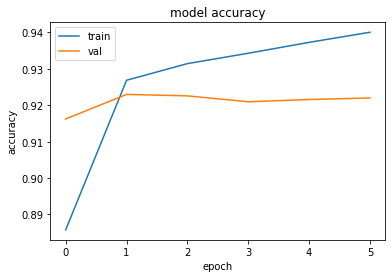

In [23]:
from matplotlib import pyplot as plt

plt.plot(lstmhist.history['accuracy'])
plt.plot(lstmhist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

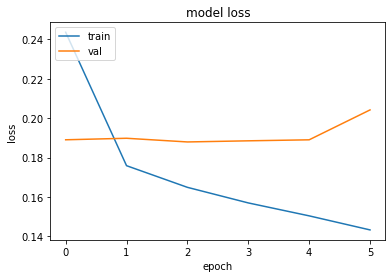

In [22]:
from matplotlib import pyplot as plt

plt.plot(lstmhist.history['loss'])
plt.plot(lstmhist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
import plotly.express as px

from sklearn.metrics import precision_recall_curve, auc
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, lstm_y, pos_label=1)
print(auc(fpr, tpr))
precision, recall, thresholds = precision_recall_curve(y_test, lstm_y)

fig = px.area(
    x=recall, y=precision,
    title=f'Precision-Recall Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='Recall', y='Precision'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

0.8204896825684769
